### RNN Model for Stock Analysis

1. import data from csv datsets
    - prices
    - sector and industry 
    - revenue
    - profit
2. compile into timestep sequence
3. create lagged y-value set
4. create model
    - lstm cell
    - dense layer
    - consider another lstm and dense layer
    - output
5. run model based on following inputs for each time step
    - market cap
    - industry (one-hot vector)
    - sector (one-hot vector)
    - revenue
    - profit
6. predict
    - run model up until the known value is done
    - iterate through following values feeding previous output and hidden state

#### Initialize definitions

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

# using tensorflow.keras may be necessary, keras by itself may not work
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, TimeDistributed, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

In [2]:
# define constants and filepaths

shareprices_path = 'data/us-shareprices-daily.csv'
income_path = 'data/us-income-ttm.csv'
# shareprices_path = 'us-shareprices-latest.csv' # latest data only, helps shorten load time while developing

MAX_DAYS = 9000 # number of total days possible for a stock
T_x = 180 # number of timesteps
T_y = 1 # number of outputs, T_x = T_y, or 1, depending on the architecture
n_a = 64 # number of hidden activation units
n_values = 1 # number of output predicted variables
n_trailing = T_x # number of trailing days used for prediction
n_lag = 15 # number of timesteps in advance for forward prediction
m = 1500 # number of training examples

sc = MinMaxScaler(feature_range=(0,1))

Data Preparation:

1. Import all datasets using pandas
2. Add revenue, profit, and yoy growth by quarter to dataset
    - Make data repeat until following quarter
3. Create a second dataset with sector of the company
4. Slice dataset into arrays of length T_x+1 and pair with sector

In [184]:
def load_dataset(path, cols=None, delimiter=';'):
    
    """
    Loads a dataset from csv file into pandas dataframe.
    
    Parameters:
    path -- filepath to csv
    cols -- column names to pass into reader, first column should be the date column name
    delimiter -- delimiter of values, default semicolon based on project data
    
    Returns:
    df -- dataframe with values from csv
    """
    
    df = pd.read_csv(path, delimiter=delimiter, usecols=cols)
    df.index = pd.to_datetime(df.pop(cols[0])) # alternatively, df.index = pd.to_datetime(df[cols[0]]); df = df.drop(columns=[cols[0]])
    df.index.name = 'Date' # renames column if date column originally has different name
    
    return df

In [384]:
def add_percent_change_by_group(df, group, values, col_name, periods=4):
    
    """
    Computes the percent change of a value, backfills missing data, and adds it to an existing dataframe.
    
    Parameters:
    df -- input dataframe
    group -- column of grouping
    values -- column of values to compute percent change
    periods -- number of periods between percent change computation
    
    Returns:
    df -- dataframe with percent change added as last column
    """
    
    growth = lambda x: x.pct_change(periods=periods).backfill()
    growth_col = df.groupby(group)[values].apply(growth)
    df[col_name] = growth_col
    
    return df

In [442]:
def clean_data(df):
    
    """
    Removes rows with incomplete revenue data.
    
    Parameters:
    df -- input dataframe
    
    Returns:
    df -- dataframe with data cleaned
    """
    
    df = df.dropna(subset=['Revenue']) # removes all rows with revenue NaN, df.dropna(subset=['Revenue'], inplace=True) also works if SettingWithCopyWarning appears
    df = df[df['Revenue'] != 0] # removes all rows with revenue 0, see https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
    df = df[df.groupby('Ticker')['Ticker'].transform(len) > 4] # removes all rows of a stock if stock has less than 4 entries, see https://stackoverflow.com/a/48514338/6501621
    
    return df

In [447]:
def access_ticker(df, ticker):
    
    """
    Returns the rows of a given ticker.
    
    Parameters:
    df -- input dataframe
    ticker -- stock ticker to retrieve values of
    
    Returns:
    df -- dataframe of rows of selected ticker
    """
    
    return df[df['Ticker']==ticker]

In [449]:
cols = ['Publish Date', 'Ticker', 'SimFinId', 'Revenue', 'Gross Profit', 'Net Income']
df_income = load_dataset(path=income_path, cols=cols)
df_income = add_percent_change_by_group(df=df_income, group='Ticker', values='Revenue', col_name='YoY Revenue', periods=4)
df_income = clean_data(df_income)

In [451]:
# attempt 3 to change quarterly frequency to daily

expand = lambda x: x.asfreq('1D').pad() # upsamples from quarterly to daily data, pad with most recent value
df_income_temp = df_income.copy()
df_income = df_income_temp.groupby('Ticker').apply(expand)
df_income.pop('Ticker') # remove duplicate column
# newdf = df.pivot_table(newdf, index=['Ticker', 'Date'])
# newdf.loc['A']
df_income

SimFinId       Revenue  Gross Profit   Net Income  \
Ticker Date                                                            
A      2010-10-06   45846.0  5.035000e+09  2.730000e+09  417000000.0   
       2010-10-07   45846.0  5.035000e+09  2.730000e+09  417000000.0   
       2010-10-08   45846.0  5.035000e+09  2.730000e+09  417000000.0   
       2010-10-09   45846.0  5.035000e+09  2.730000e+09  417000000.0   
       2010-10-10   45846.0  5.035000e+09  2.730000e+09  417000000.0   
...                     ...           ...           ...          ...   
ZYXI   2020-02-23  171401.0  4.064700e+07  3.282300e+07    9165000.0   
       2020-02-24  171401.0  4.064700e+07  3.282300e+07    9165000.0   
       2020-02-25  171401.0  4.064700e+07  3.282300e+07    9165000.0   
       2020-02-26  171401.0  4.064700e+07  3.282300e+07    9165000.0   
       2020-02-27  171401.0  4.547200e+07  3.665800e+07    9492000.0   

                   YoY Revenue  
Ticker Date                     
A      2010-10-06     0.283615  
       2010-10-07     0.283615  
       2010-10-08     0.283615  
       2010-10-09     0.283615  
       2010-10-10     0.283615  
...                        ...  
ZYXI   2020-02-23     0.323403  
       2020-02-24     0.323403  
       2020-02-25     0.323403  
       2020-02-26     0.323403  
       2020-02-27     0.424695  

[5708264 rows x 5 columns]

<AxesSubplot:xlabel='Date'>

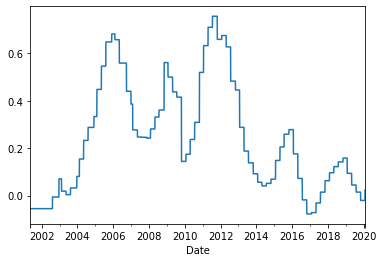

In [189]:
df_income.loc['AAPL']['YoY Revenue']

plt.figure()
df_income.loc['AAPL']['YoY Revenue'].plot()

In [452]:
cols = ['Date', 'Ticker', 'Close', 'Shares Outstanding', 'Volume']
df_prices = load_dataset(path=shareprices_path, cols=cols)

In [455]:
# newdf.merge(df2, left_on=['Ticker', 'Date'], right_on=['Ticker', 'Date'])

df_main = df_income.merge(df_prices, on=['Date', 'Ticker'], how='inner')

In [456]:
df_main

,Ticker,SimFinId,Revenue,Gross Profit,Net Income,YoY Revenue,Close,Volume,Shares Outstanding
Date,,,,,,,,,
2010-10-06,A,45846.0,5.035000e+09,2.730000e+09,417000000.0,0.283615,32.67,3234800,346370351.0
2010-10-07,A,45846.0,5.035000e+09,2.730000e+09,417000000.0,0.283615,33.20,3737200,346370351.0
2010-10-08,A,45846.0,5.035000e+09,2.730000e+09,417000000.0,0.283615,33.80,2863400,346370351.0
2010-10-11,A,45846.0,5.035000e+09,2.730000e+09,417000000.0,0.283615,33.75,1917200,346370351.0
2010-10-12,A,45846.0,5.035000e+09,2.730000e+09,417000000.0,0.283615,33.68,3442200,346370351.0
...,...,...,...,...,...,...,...,...,...
2020-02-21,ZYXI,171401.0,4.064700e+07,3.282300e+07,9165000.0,0.323403,11.86,692467,32791665.0
2020-02-24,ZYXI,171401.0,4.064700e+07,3.282300e+07,9165000.0,0.323403,13.36,1209423,32791665.0
2020-02-25,ZYXI,171401.0,4.064700e+07,3.282300e+07,9165000.0,0.323403,12.72,476828,32791665.0


In [76]:
df_main.loc['AAPL']

KeyError: False

In [133]:
export = lambda x: x.to_numpy()
dataset = df_main.groupby('Ticker').apply(export)

In [139]:
dataset['AAPL']

array([[111052.0, 2001.0, 'Q2', ..., nan, nan, nan],
       [111052.0, 2001.0, 'Q2', ..., nan, nan, nan],
       [111052.0, 2001.0, 'Q2', ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 61.67, 17501920000.0, 75058406.0],
       [nan, nan, nan, ..., 61.2, 17501920000.0, 67964255.0],
       [nan, nan, nan, ..., 57.31, 17501920000.0, 100423346.0]],
      dtype=object)

#### Model Attempt 4

Data preparation methods below are for model versions up to 4.1.

In [3]:
# load prices of shares from the daily share price values
# for with open as f documentation, see https://likegeeks.com/numpy-loadtxt-tutorial

with open(shareprices_path) as f:
    cols = f.readline().split(';')
    sample = f.readline().split(';')

# identify columns of interest and indices

col_names = ['Ticker', 'SimFinId', 'Date', '"Adj. Close"', '"Shares Outstanding"\n']
col_nums = []
for name in col_names:
    col_nums.append(cols.index(name))
col_names = ['Ticker', 'SimFinId', 'Date', 'Price', 'Shares']
    
# for cols.index documentation, see https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list
# using np.genfromtxt instead of np.loadtxt because more flexibility with datatype (and no issue with floats)

prices = np.genfromtxt(open(shareprices_path), 
                    delimiter=';', 
                    skip_header=1, 
                    usecols=(col_nums), 
                    dtype={'names': col_names,
                     'formats': ('U6', 'i8', 'U10', 'f8', 'i8')})

In [4]:
def get_stock_price(prices, ticker):
    
    """
    Retrieves the stock price of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    
    Return:
    price -- numpy array of price
    """
    
    price = marketcap = prices[prices['Ticker']==ticker]['Price']
    
    return price

In [5]:
def get_market_cap(prices, ticker, threshold=0.5):
    
    """
    Retrieves the market cap of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    threshold -- minimum market cap acceptable in output, in order to add robustness (default 0.5B)
    
    Return:
    marketcap -- numpy array of market cap, in billions
    """
    
    marketcap = prices[prices['Ticker']==ticker]['Price'] * prices[prices['Ticker']==ticker]['Shares'] / 1000000000
    marketcap = marketcap[marketcap>threshold]
    
    return marketcap

In [6]:
def prep_dataset(size):
    
    """
    Creates the dataset for training
    """
    
    # finds all stock tickers and randomly selects
    
    tickers = list(set(prices['Ticker']))
    ticker_set = random.sample(tickers, k=size)
    
    divisor = int(MAX_DAYS/T_x) # reduces dataset by a factor of divisor to fit within T_x timesteps
    
    # initialize output variables
    
    full_dataset = np.zeros((len(ticker_set), T_x+n_lag)) # very large number temporarily
    X = np.zeros((len(ticker_set), T_x))
    Y = np.zeros((len(ticker_set), T_x))
    
    # loop through tickers to compile dataset
    
    for i, ticker in enumerate(ticker_set):
        
        # retrieve market cap and number of values
        
        marketcap = get_market_cap(prices, ticker, threshold=2.0)
        n_prices = len(marketcap)
        
        marketcap = marketcap[::divisor] # reduces length of array by a factor of dataset to keep within T_x timesteps
        n_prices = len(marketcap)
        
        # apply values to dataset and variables
        
        full_dataset[i, full_dataset.shape[1]-n_prices:] = marketcap
    
#     full_dataset = sc.fit_transform(full_dataset)
    
    for i, ticker in enumerate(ticker_set):
        X[i, :] = full_dataset[i, :full_dataset.shape[1]-n_lag]
        Y[i] = full_dataset[i, n_lag:]
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
    
    return full_dataset, X, Y, ticker_set

In [34]:
aaplmktcap = get_market_cap(prices, 'AAPL')

In [35]:
num_days_aapl = len(aaplmktcap)
dataset = np.zeros((num_days_aapl-n_trailing-n_lag+1, n_trailing+1)) # make sure the shape of np array is correct
for i in range(num_days_aapl-n_trailing-n_lag+1):
    dataset[i] = np.append(aaplmktcap[i:i+n_trailing], aaplmktcap[i+n_trailing+n_lag-1]) # make sure to include [start:end] correct syntax
X = dataset[:,:-1]
Y = dataset[:,-1:]
print(Y)

[[ 105.84970813]
 [ 105.09722205]
 [ 106.85302289]
 ...
 [1070.9424848 ]
 [1062.8916016 ]
 [ 995.3341904 ]]


In [36]:
def model4():
    
    """
    Uses an LSTM model with dense layers to predict n_lag days in advance, distinct from other models in only yielding one prediction.
    Version: 4.1
    """
    
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = Dense(units=256)(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=64)(X)
    output = Dense(units=1, activation='relu')(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [ ]:
def model4_v0():
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128)(X_input)
    output = Dense(units=1, activation='relu')(X)
    model = Model(inputs=X_input, outputs=output)
    return model

In [37]:
model = model4()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 180, 128)          66560     
_________________________________________________________________
dense_8 (Dense)              (None, 180, 256)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

In [38]:
X = X.reshape(X.shape[0], X.shape[1], 1)
model.fit(X, Y, batch_size=32, epochs=15) # small batch size (batch_size < 64) helps

Train on 2695 samples
Epoch 1/15
2695/2695 [==============================] - 83s 31ms/sample - loss: 305480.1206 - mean_squared_error: 305480.1562
Epoch 2/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 131569.7970 - mean_squared_error: 131569.8281
Epoch 3/15
2695/2695 [==============================] - 77s 28ms/sample - loss: 75596.6667 - mean_squared_error: 75596.6562
Epoch 4/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 37749.7734 - mean_squared_error: 37749.7812
Epoch 5/15
2695/2695 [==============================] - 77s 29ms/sample - loss: 12667.9320 - mean_squared_error: 12667.9307
Epoch 6/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 7951.2288 - mean_squared_error: 7951.2290
Epoch 7/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 6831.0970 - mean_squared_error: 6831.0981
Epoch 8/15
2695/2695 [==============================] - 79s 29ms/sample - loss: 5760.5596 - mean_squared_error

In [39]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-1300:-n_lag-1300])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


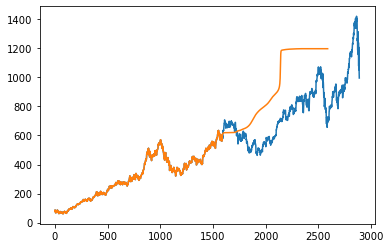

In [40]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-1300], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)